In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
traindf=pd.read_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/train_add3.csv")
traindf.head()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, sharey=True, figsize=[15, 5])
# sns.distplot(traindf['number of horizontal rebars'], kde=False, color='r', ax=ax[0])
# sns.distplot(traindf['number of vertical rebars'], kde=False, color='r', ax=ax[1])
sns.distplot(traindf['Total rebars'], kde=False, color='r', ax=ax[2])

In [0]:
testdf=pd.read_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/testName.csv")
testdf.head()

In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator

# base_dir = '.\\train_img'
# train_dir = os.path.join(base_dir, 'train_img')
train_dir = 'drive/My Drive/Colab Notebooks/Final Project/Task 1/totalDepthPic'
test_dir = 'drive/My Drive/Colab Notebooks/Final Project/Task 1/totalDepthPic'
BATCH_SIZE = 30

datagen = ImageDataGenerator(
    # width_shift_range=10,
    # height_shift_range=10,
    # rotation_range=15,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    rescale=1./255., 
    validation_split=0.25
)
train_generator=datagen.flow_from_dataframe( 
    dataframe=traindf, 
    directory=train_dir, 
    x_col='Pic Name', 
    y_col='Total rebars', 
    has_ext=False, 
    subset="training", 
    class_mode="raw", 
    batch_size=BATCH_SIZE,
    target_size=(150, 150)
)

validation_generator=datagen.flow_from_dataframe( 
    dataframe=traindf, 
    directory=train_dir,
    x_col='Pic Name', 
    y_col='Total rebars', 
    has_ext=False, 
    subset="validation", 
    class_mode="raw",
    batch_size=BATCH_SIZE,
    target_size=(150, 150)
    )

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=test_dir,
    x_col='Pic Name',
    target_size=(150, 150),
    color_mode='rgb',
    shuffle=False,
    class_mode=None
)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="Pic Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 820 validated image filenames.
Found 273 validated image filenames.
Found 101 validated image filenames.


In [0]:
from keras.applications.resnet_v2 import ResNet50V2

base = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation=None))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 50,042,881
Trainable params: 49,997,441
Non-trainable params: 45,440
_____________________________________

In [0]:
from keras import models

saved_model = models.load_model('drive/My Drive/Colab Notebooks/Final Project/Task 1/yomodel1221.h5')

In [0]:
import keras.backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
from keras import optimizers

model.compile(
# saved_model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss=RMSE,
    metrics=[RMSE]
)

In [0]:
history = model.fit_generator(
# history = saved_model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50
)

In [0]:
model.save('drive/My Drive/Colab Notebooks/Final Project/Task 1/yomodel.h5')
# saved_model.save('drive/My Drive/Colab Notebooks/Final Project/Task 1/yomodel1222.h5')

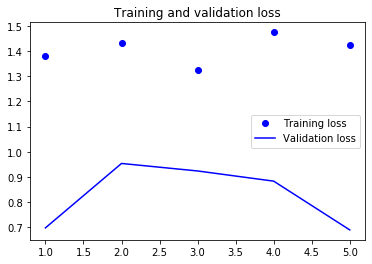

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
pred = model.predict_generator(test_generator)
pred

In [0]:
# pred_int = pred.astype('int')
testdf['Total rebars'] = pred
testdf.head()

In [0]:
testdf.to_csv(
    "drive/My Drive/Colab Notebooks/Final Project/Task 1/Result/yoresult39.csv", 
    index=False, 
    encoding='utf-8'
)